# Определение перспективного тарифа для телекомкомпании

Пользователям предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Есть данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

План анализа:

загрузить таблицы
провести анализ этих таблиц (что за данные, какие типы данных, сколько столбцов и строк), определить проблемы с данными.
провести предобработку данных
поменять типы данных
согласно условиям оператора округляем время звонков и интернета за большего целого
добавить столбец с месяцем, когда производился звонок, отправлялась смс и был выход в интернет
формируем единую таблицу по месяцам и звонков, интернета и смс
пишем функцию, которая считаем прибыль по месяцам
формируем таблицы с тарифами
считаем дисперсию, стандартное отклонение, среднее по каждому показателю
строим графики зависимости двух тарифов по всем показателям
анализ графиков
строим гипотезу различия двух тарифов
строим гипотезу различия среднего в Москве и в других районах
итоговый вывод

## Импортирование необходимых данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Подготовка данных

### Изучим типы и наличие пропусков с данных

In [2]:
 #просмотрим данные о всех таблицах
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


calls-это таблица с звонками всех пользователей. Состоит из 4 столбцов и 202607 строк. Пропущенных значений нет.

In [3]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


internet-это дата с звонками всех пользователей. Состоит из 4 столбцов и 149396 строк. Пропущенных значений нет.

In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB



messages-это дата с использованными сообщениями всех пользователей. Состоит из 3 столбцов и 123036 строк. Пропущенных значений нет.

In [5]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


tariffs-это дата с информацией о тарифах. Состоит из 8 столбцов и 2 строк. Пропущенных значений нет.

In [6]:
print(users['tariff'])


0      ultra
1      smart
2      smart
3      ultra
4      ultra
       ...  
495    ultra
496    smart
497    smart
498    smart
499    smart
Name: tariff, Length: 500, dtype: object


users-это дата с информацией о пользователях. Состоит из 8 столбцов и 500 строк. Пропущенные значения есть. У столбца churn_date есть 462 пропуска.Это столбец с датой прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). В полследствии можно заменить на 0

**Общий вывод: Есть проблемы в данных. Надо менять типы данных в датах. Вещественный тип в звонках, потреблении интернета и кл-ве смс переведем в целочисленный. Присутствуют пропуски в churn_date. Есть смысл их просто поменять на 0(значит смены оператора не было). В соответствии требования оператора округлить длительность звонка и потребление интернета до целого большего.**

### Предобработка данных

In [7]:
calls['call_date']=pd.to_datetime(calls['call_date'],format='%Y-%m-%d') #Во всех столбцах где есть дата меняем тип на date_time
messages['message_date']=pd.to_datetime(messages['message_date'],format='%Y-%m-%d %H:%M:%S') #Значения потраченных минут переводим в целоцисленные
# округляю количество мб до целого большего
internet['mb_used'].value_counts()

0.00      19598
197.56        9
447.30        9
335.91        9
108.95        8
          ...  
72.49         1
846.22        1
429.17        1
899.03        1
483.87        1
Name: mb_used, Length: 70003, dtype: int64

In [8]:
calls=calls.query('duration>0') #Избавился от 0. Возможно это недозвоны
calls['duration']=np.ceil(calls['duration']) # все значение меньше 1 округляем до большего целого
calls['duration'].value_counts()

7.0     11510
6.0     11457
5.0     11411
8.0     11272
9.0     10973
4.0     10918
3.0     10362
10.0    10186
11.0     9385
2.0      9194
12.0     8448
1.0      8402
13.0     7486
14.0     6554
15.0     5505
16.0     4551
17.0     3671
18.0     2984
19.0     2411
20.0     1806
21.0     1304
22.0      975
23.0      720
24.0      468
25.0      363
26.0      257
27.0      151
28.0      104
29.0       56
30.0       39
31.0       30
32.0       17
33.0       10
35.0        5
34.0        3
38.0        2
36.0        2
37.0        2
Name: duration, dtype: int64

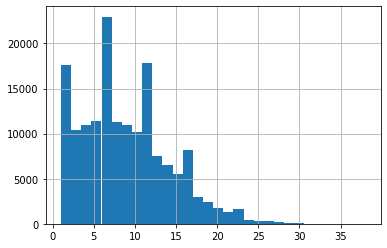

In [9]:
internet['session_date']=pd.to_datetime(internet['session_date'],format='%Y-%m-%d')
users['churn_date']=pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
users['reg_date']=pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
calls['duration'].hist(bins=30) # строю гист. всех звонков

**Вывод: По гистограмме видно что больше всего звонков по 4 минуте и 6 минут**

In [10]:
#Создаем сводную таблицу по месяцам и звонкам 
calls['month']=calls['call_date'].dt.month
group_calls=calls.pivot_table(index=['month','user_id'],values='duration',aggfunc=('sum'))
group_calls

duration
month user_id          
1     1005         95.0
      1032        380.0
      1045          9.0
      1055        551.0
      1071        194.0
...                 ...
12    1494        418.0
      1495       1031.0
      1496        518.0
      1497        545.0
      1499        492.0

[3168 rows x 1 columns]

In [11]:
#Создаем сводную таблицу по месяцам и сообщениям 
messages['month']=messages['message_date'].dt.month # добавляю столбец месяц
group_messages=messages.pivot_table(index=['month','user_id'],values='message_date',aggfunc=('count'))
group_messages

message_date
month user_id              
1     1005                7
      1032               38
      1045                5
      1055               30
      1071               16
...                     ...
12    1493               78
      1495               84
      1496               51
      1497               17
      1499               66

[2717 rows x 1 columns]

In [12]:
#Создаем сводную таблицу интренету
internet['month']=internet['session_date'].dt.month # добавляю столбец месяц
internet['mb_used']=round(internet['mb_used'].astype('int64')+0.45)
group_internet=internet.pivot_table(index=['month','user_id'],values='mb_used',aggfunc=('sum'))
group_internet

mb_used
month user_id         
1     1005      2724.0
      1032     24100.0
      1045      2343.0
      1055     17069.0
      1071     15585.0
...                ...
12    1494     17601.0
      1495     23404.0
      1496     20702.0
      1497     19899.0
      1499     13037.0

[3203 rows x 1 columns]

In [13]:

group_messages_call=group_messages.merge(group_calls,on=['user_id','month'],how='outer') # 
group_all=group_messages_call.merge(group_internet,on=['user_id','month'],how='outer')
users['month']=users['reg_date'].dt.month
group_all=group_all.merge(users,on=['user_id'],how='outer')
group_all

,user_id,message_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,month
0,1005,7.0,95.0,2724.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1
1,1005,38.0,456.0,7372.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1
2,1005,56.0,606.0,11092.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1
3,1005,41.0,712.0,9341.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1
4,1005,42.0,595.0,7857.0,67,NaT,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,1
...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1129,NaN,452.0,16422.0,48,NaT,Курган,Анвар,Морозов,2018-12-17,smart,12
3212,1297,NaN,404.0,18963.0,66,NaT,Иркутск,Радим,Абрамцев,2018-12-04,smart,12
3213,1397,NaN,232.0,23509.0,47,NaT,Воронеж,Инна,Чистякова,2018-12-22,ultra,12
3214,1128,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,12


In [14]:
group_all=group_all.fillna(0).sort_values(by='user_id')
group_all['city']=group_all['city'].replace([0], 'Город')
group_all

,user_id,message_date,duration,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,month
1417,1000,57.0,466.0,14556.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1420,1000,70.0,333.0,9808.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1419,1000,58.0,338.0,14745.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1418,1000,73.0,350.0,14690.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
1416,1000,81.0,408.0,14043.0,52,0,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2183,1498,20.0,175.0,7469.0,68,2018-10-25 00:00:00,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,7
2519,1499,66.0,492.0,13037.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9
2518,1499,59.0,612.0,17945.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9
2516,1499,11.0,70.0,1844.0,35,0,Пермь,Гектор,Корнилов,2018-09-27,smart,9


In [15]:
#необходимо удалить все ненужные столбцы и заменить  NaN
#group_all=group_all.fillna(tariff).sort_values(by='user_id')
#group_all['city']=group_all['city'].replace([0], 'Город')

del group_all['age']
del group_all['churn_date']
del group_all['first_name']
del group_all['last_name']
del group_all['reg_date']
group_all

,user_id,message_date,duration,mb_used,city,tariff,month
1417,1000,57.0,466.0,14556.0,Краснодар,ultra,5
1420,1000,70.0,333.0,9808.0,Краснодар,ultra,5
1419,1000,58.0,338.0,14745.0,Краснодар,ultra,5
1418,1000,73.0,350.0,14690.0,Краснодар,ultra,5
1416,1000,81.0,408.0,14043.0,Краснодар,ultra,5
...,...,...,...,...,...,...,...
2183,1498,20.0,175.0,7469.0,Владикавказ,smart,7
2519,1499,66.0,492.0,13037.0,Пермь,smart,9
2518,1499,59.0,612.0,17945.0,Пермь,smart,9
2516,1499,11.0,70.0,1844.0,Пермь,smart,9


## Анализ данных

In [16]:
#создаем функцию посчета выручки в зависимости от тарифа, добавляем ее при помощи apply в нашу таблицу

def how_money(row):
    
    message=row['message_date']
    call=row['duration']
    inet=row['mb_used']
    tariff=row['tariff']
    
    
    if (tariff=='smart'):
        i=0
    else:
        i=1
        
    remains_call=tariffs['minutes_included'][i]-call
    if remains_call<0:
        call_money=-remains_call*tariffs['rub_per_minute'][i]
    else:
        call_money=0
         
    remains_internet=tariffs['mb_per_month_included'][i]-inet
    if remains_internet<0:
        internet_money=round((-remains_internet/1024))*tariffs['rub_per_gb'][i]
    else:
        internet_money=0
            
    remains_messages=tariffs['messages_included'][i]-message
    if remains_messages<0:
        messages_money=-remains_messages*tariffs['rub_per_message'][i]
    else:
        messages_money=0
            
    money=call_money+internet_money+messages_money+tariffs['rub_monthly_fee'][i]
    return money
group_all['money']=group_all.apply(how_money,axis=1)   

#group_all.loc[group_all['money'] >= 1950, 'money'] = 1
group_all


,user_id,message_date,duration,mb_used,city,tariff,month,money
1417,1000,57.0,466.0,14556.0,Краснодар,ultra,5,1950.0
1420,1000,70.0,333.0,9808.0,Краснодар,ultra,5,1950.0
1419,1000,58.0,338.0,14745.0,Краснодар,ultra,5,1950.0
1418,1000,73.0,350.0,14690.0,Краснодар,ultra,5,1950.0
1416,1000,81.0,408.0,14043.0,Краснодар,ultra,5,1950.0
...,...,...,...,...,...,...,...,...
2183,1498,20.0,175.0,7469.0,Владикавказ,smart,7,550.0
2519,1499,66.0,492.0,13037.0,Пермь,smart,9,598.0
2518,1499,59.0,612.0,17945.0,Пермь,smart,9,1513.0
2516,1499,11.0,70.0,1844.0,Пермь,smart,9,550.0


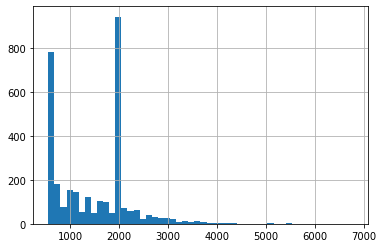

In [17]:
#Потсроим гистрограмму, для анализа количества по стоимости тарифов
group_all['money'].hist(bins=50);


**Вывод: больше всего тарифов за 1950 и 550 рублей**

In [18]:
#группируем таблицу по столбцу тариф и считаем сумму каждого тарифа в таблице
group_all.groupby('tariff')['money'].sum()

tariff
smart    2731301.0
ultra    2029800.0
Name: money, dtype: float64

In [19]:
#далее найдем тарифы у которых стомиость более 1950
group_all.query('tariff=="ultra" and money>1950')


,user_id,message_date,duration,mb_used,city,tariff,month,money
3181,1024,0.0,949.0,35913.0,Санкт-Петербург,ultra,10,2700.0
3180,1024,0.0,1146.0,43069.0,Санкт-Петербург,ultra,10,3750.0
1733,1050,52.0,209.0,35139.0,Тюмень,ultra,6,2550.0
2649,1060,52.0,1233.0,43893.0,Калуга,ultra,11,3900.0
2419,1124,95.0,1127.0,36812.0,Махачкала,ultra,9,2850.0
...,...,...,...,...,...,...,...,...
3117,1469,0.0,795.0,35463.0,Сочи,ultra,7,2700.0
2703,1474,105.0,1345.0,42285.0,Набережные Челны,ultra,11,3600.0
2707,1493,78.0,571.0,42700.0,Красноярск,ultra,11,3750.0
2403,1495,79.0,954.0,38903.0,Иркутск,ultra,8,3150.0


In [20]:
#далее найдем тарифы у которых стомиость менее 550, так как из больше то найдем количетсво
group_all.query('tariff=="smart" and money>550').count()

user_id         1618
message_date    1618
duration        1618
mb_used         1618
city            1618
tariff          1618
month           1618
money           1618
dtype: int64

**отсюда делаем вывод что самый выгодный для компании тариф ультра**

In [21]:
#для дальнейшей работы нам необходимо поделить таблицу на две с разными тарифами, сделав сводную по месяцам
tariff_ultra=(group_all
     .query('tariff=="ultra"')
     .pivot_table(index='month',values=('duration','message_date','mb_used'),aggfunc=('sum'))
     #.plot(y='mb_used',grid=True,figsize=(13,6),style='o-',kind='bar',label='ultra')
)

tariff_smart=(group_all
     .query('tariff=="smart"')
     .pivot_table(index='month',values=('duration','message_date','mb_used'),aggfunc=('sum'))
             )                                                                                     

In [22]:
tariff_ultra

,duration,mb_used,message_date
month,,,
1,65091.0,2220669.0,4872.0
2,70763.0,3283284.0,6283.0
3,79139.0,1862369.0,3110.0
4,94163.0,3411474.0,6615.0
5,35370.0,1876374.0,6406.0
6,52854.0,2440772.0,6682.0
7,24428.0,786228.0,2549.0
8,41674.0,1220045.0,5683.0
9,21125.0,592353.0,2204.0


In [23]:
tariff_smart

,duration,mb_used,message_date
month,,,
1,158985.0,6388775.0,13777.0
2,103485.0,3885841.0,9082.0
3,87927.0,3261994.0,7015.0
4,138343.0,5029267.0,11380.0
5,95698.0,4060832.0,7831.0
6,61535.0,2696077.0,4321.0
7,96162.0,3439017.0,7190.0
8,67073.0,2785461.0,4782.0
9,42352.0,1667916.0,3566.0


**отделив данные таблицы можем посмотреть сколько было потрачено на звонки, сообщения и интрнет на кадом тарифе в месяц**

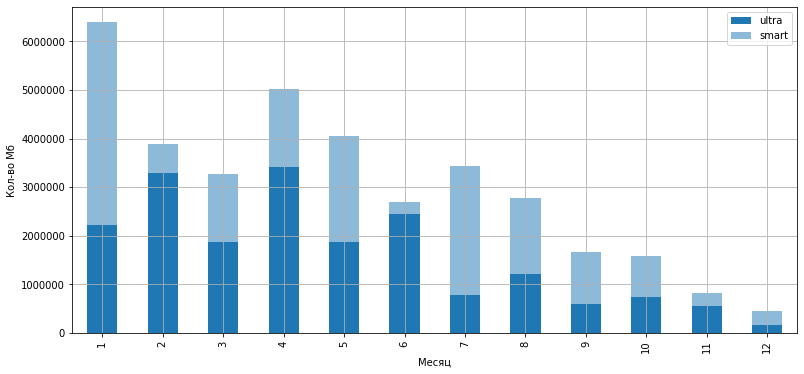

In [24]:
#построим графики для наглядного сравнения потребления звонков, сообщений и интернета
ax=tariff_ultra.plot(y='mb_used',figsize=(13,6),kind='bar',label='ultra',style='o-')
tariff_smart.plot(y='mb_used',grid=True,figsize=(13,6),style='o-',kind='bar',label='smart',alpha=0.5,ax=ax)
plt.xlabel('Месяц')
plt.ylabel('Кол-во Мб')
plt.show()

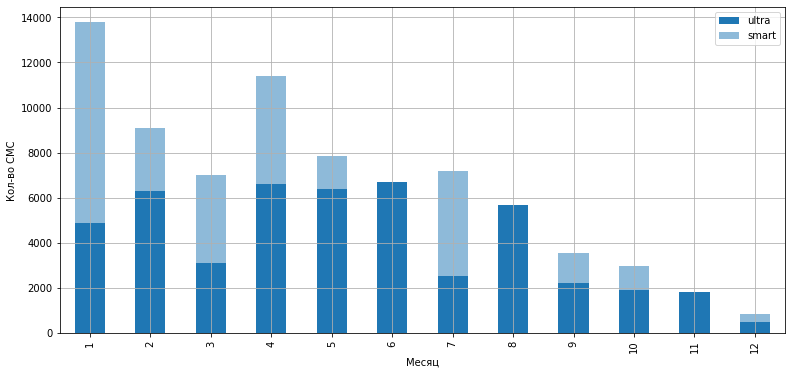

In [25]:
ax=tariff_ultra.plot(y='message_date',grid=True,figsize=(13,6),style='o-',kind='bar',label='ultra')

tariff_smart.plot(y='message_date',grid=True,figsize=(13,6),style='o-',kind='bar',label='smart',alpha=0.5,ax=ax);
plt.xlabel('Месяц')
plt.ylabel('Кол-во СМС')
plt.show()

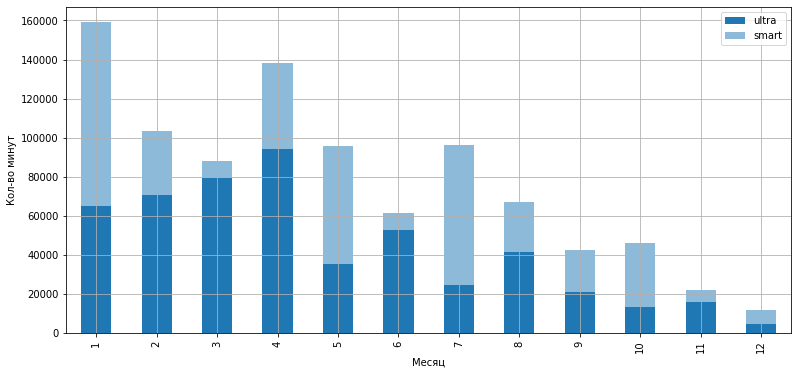

In [26]:
ax=tariff_ultra.plot(y='duration',figsize=(13,6),style='o-',kind='bar',label='ultra')

tariff_smart.plot(y='duration',grid=True,figsize=(13,6),style='o-',kind='bar',label='smart',alpha=0.5,ax=ax);
plt.xlabel('Месяц')
plt.ylabel('Кол-во минут')
plt.show()

**на основе 3х гррафиков можно сделать вывод, что в потреблении лидирует тариф Смарт, но в сообщениях тариф Ультра поднялся**

#### Срез по месяцам для Ультра и расчета средних значений по звонка, сообщениям, интернету

In [27]:
mean_ultra=(group_all
     .query('tariff=="ultra"')
     .pivot_table(index='month',values=('duration','message_date','mb_used'))    
)
mean_ultra.set_axis(['mean_duration','mean_mb_used','mean_message'],axis='columns',inplace=True)
mean_ultra

,mean_duration,mean_mb_used,mean_message
month,,,
1,625.875000,21352.586538,46.846154
2,445.050314,20649.584906,39.515723
3,608.761538,14325.915385,23.923077
4,581.253086,21058.481481,40.833333
5,376.276596,19961.425532,68.148936
6,459.600000,21224.104348,58.104348
7,595.804878,19176.292683,62.170732
8,534.282051,15641.602564,72.858974
9,603.571429,16924.371429,62.971429


In [28]:
tariff_ultra

,duration,mb_used,message_date
month,,,
1,65091.0,2220669.0,4872.0
2,70763.0,3283284.0,6283.0
3,79139.0,1862369.0,3110.0
4,94163.0,3411474.0,6615.0
5,35370.0,1876374.0,6406.0
6,52854.0,2440772.0,6682.0
7,24428.0,786228.0,2549.0
8,41674.0,1220045.0,5683.0
9,21125.0,592353.0,2204.0


In [29]:
print(tariff_ultra.mean())
print(tariff_smart.mean())

#исправление по 2 коментариям. дисперсия
print('Дисперсия')
print(np.var(tariff_ultra))
print(np.var(tariff_smart))
# станд. отклонение
print('Станд. отклонения')
print(np.std(tariff_ultra, ddof=1))
print(np.std(tariff_smart, ddof=1))



duration        4.322700e+04
mb_used         1.596574e+06
message_date    4.051917e+03
dtype: float64
duration        7.763142e+04
mb_used         3.006843e+06
message_date    6.201083e+03
dtype: float64
Дисперсия
duration        7.692833e+08
mb_used         1.087642e+12
message_date    4.683673e+06
dtype: float64
duration        1.813993e+09
mb_used         2.739337e+12
message_date    1.409289e+07
dtype: float64
Станд. отклонения
duration        2.896926e+04
mb_used         1.089274e+06
message_date    2.260412e+03
dtype: float64
duration        4.448484e+04
mb_used         1.728690e+06
message_date    3.920977e+03
dtype: float64


Среднее для тарифа ultra равна 526.08925
Дисперсия для тарифа ultra равна 101052.49355
Ст. отклонение для тарифа ultra равна 526.08925

Среднее для тарифа smart равна 417.74753
Дисперсия для тарифа smart равна 36281.39384
Ст. отклонение для тарифа smart равна 417.74753



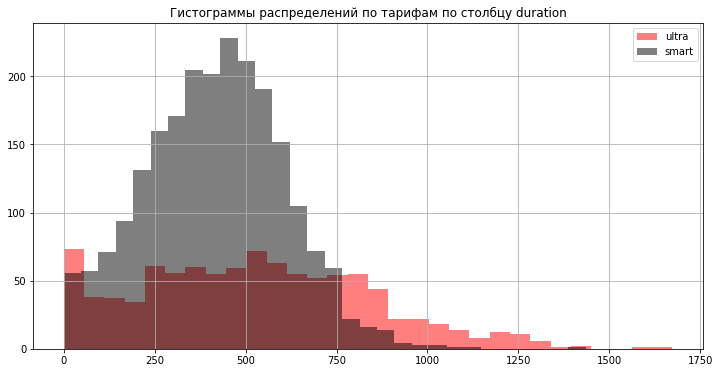

In [30]:
col = 'duration'

color_dict = {'ultra': 'red', 'smart': 'black'}
fig = plt.figure(figsize=(12, 6))

for tariff in ['ultra', 'smart']:
    print(f"Среднее для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print(f"Дисперсия для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].var(), 5)}")
    print(f"Ст. отклонение для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print()
    
    plt.hist(group_all.query('tariff == @tariff')[col],alpha=0.5, bins=30, label=tariff, color=color_dict[tariff])
        
plt.legend()
plt.grid()
plt.title(f'Гистограммы распределений по тарифам по столбцу {col}')
plt.show()

Среднее для тарифа ultra равна 19430.91684
Дисперсия для тарифа ultra равна 101846665.40221
Ст. отклонение для тарифа ultra равна 19430.91684

Среднее для тарифа smart равна 16180.31973
Дисперсия для тарифа smart равна 34481896.73173
Ст. отклонение для тарифа smart равна 16180.31973



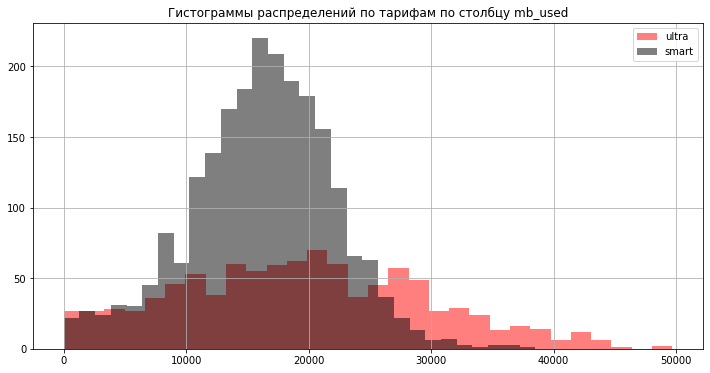

In [31]:
col = 'mb_used'

color_dict = {'ultra': 'red', 'smart': 'black'}
fig = plt.figure(figsize=(12, 6))

for tariff in ['ultra', 'smart']:
    print(f"Среднее для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print(f"Дисперсия для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].var(), 5)}")
    print(f"Ст. отклонение для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print()
    
    plt.hist(group_all.query('tariff == @tariff')[col],alpha=0.5, bins=30, label=tariff, color=color_dict[tariff])
        
plt.legend()
plt.grid()
plt.title(f'Гистограммы распределений по тарифам по столбцу {col}')
plt.show()

Среднее для тарифа ultra равна 49.31339
Дисперсия для тарифа ultra равна 2285.41742
Ст. отклонение для тарифа ultra равна 49.31339

Среднее для тарифа smart равна 33.36906
Дисперсия для тарифа smart равна 796.95526
Ст. отклонение для тарифа smart равна 33.36906



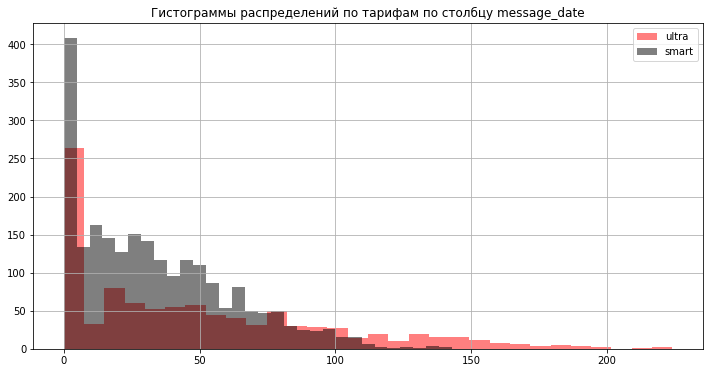

In [32]:
col = 'message_date'

color_dict = {'ultra': 'red', 'smart': 'black'}
fig = plt.figure(figsize=(12, 6))

for tariff in ['ultra', 'smart']:
    print(f"Среднее для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print(f"Дисперсия для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].var(), 5)}")
    print(f"Ст. отклонение для тарифа {tariff} равна {np.round(group_all.query('tariff == @tariff')[col].mean(), 5)}")
    print()
    
    plt.hist(group_all.query('tariff == @tariff')[col],alpha=0.5, bins=30, label=tariff, color=color_dict[tariff])
        
plt.legend()
plt.grid()
plt.title(f'Гистограммы распределений по тарифам по столбцу {col}')
plt.show()

,mean_duration,mean_mb_used,mean_message,mean_minute_for_person
month,,,,
1,625.875000,21352.586538,46.846154,66.015213
2,445.050314,20649.584906,39.515723,71.767748
3,608.761538,14325.915385,23.923077,80.262677
4,581.253086,21058.481481,40.833333,95.500000
5,376.276596,19961.425532,68.148936,35.872211
6,459.600000,21224.104348,58.104348,53.604462
7,595.804878,19176.292683,62.170732,24.774848
8,534.282051,15641.602564,72.858974,42.265720
9,603.571429,16924.371429,62.971429,21.424949


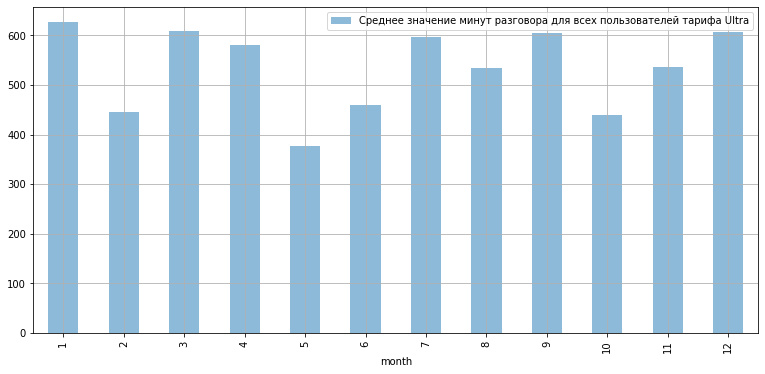

In [33]:
mean_ultra.plot(y='mean_duration',grid=True,figsize=(13,6),style='o-',kind='bar',label='Среднее значение минут разговора для всех пользователей тарифа Ultra',alpha=0.5)
mean_ultra['mean_minute_for_person']=tariff_ultra['duration']/len(group_all.query('tariff=="ultra"'))
mean_ultra

посчитали среднее время разговора пользователей на тарифе Ультра в месяц

#### Считаем дисперсию и отклонение для тарифа ультра по месяцам

In [34]:
ultra_person_calls=group_all.query('tariff=="ultra"')# записываю в переменную всех пользователей Ультра для подсчета дисперсии 
disp_sigma_ultra=ultra_person_calls.pivot_table(index='month',values='duration',aggfunc=(np.var))#Считаю дисперсию звонков
disp_sigma_ultra_messages=ultra_person_calls.pivot_table(index='month',values='message_date',aggfunc=(np.var))#Считаю дисперсию сообщений
disp_sigma_ultra_internet=ultra_person_calls.pivot_table(index='month',values='mb_used',aggfunc=(np.var))#Считаю дисперсию интернет


#### Считаем стандартное отклонение по всем показателям ультра

In [35]:
disp_sigma_ultra['sigma']=disp_sigma_ultra['duration'].apply(np.sqrt)#Считаю стандартное отклонение по звонкам
disp_sigma_ultra_messages['sigma']=disp_sigma_ultra_messages['message_date'].apply(np.sqrt)#Считаю стандартное отклонение по cообщениям
disp_sigma_ultra_internet['sigma']=disp_sigma_ultra_internet['mb_used'].apply(np.sqrt)#Считаю стандартное отклонение по интернету
disp_sigma_ultra.set_axis(['dispersion_call','sigma_call'],axis='columns',inplace=True)
disp_sigma_ultra_messages.set_axis(['dispersion_message','sigma_message'],axis='columns',inplace=True)
disp_sigma_ultra_internet.set_axis(['dispersion_internet','sigma_internet'],axis='columns',inplace=True)# Переименовываю столбцы
disp_sigma_ultra=disp_sigma_ultra.merge(disp_sigma_ultra_messages,on='month')
disp_sigma_ultra=disp_sigma_ultra.merge(disp_sigma_ultra_internet,on='month')
mean_ultra=mean_ultra.merge(disp_sigma_ultra,on='month')

#### Полная  таблица дисперсии и сигма (среднеквадратичное отклонение),средних для Ультра по месяцам

In [36]:
mean_ultra['mean_money']=group_all.query('tariff=="ultra"').pivot_table(index='month',values='money',aggfunc=('mean')) # Считаю среднее по прибыли
mean_ultra['dispersion_money']=group_all.query('tariff=="ultra"').pivot_table(index='month',values='money',aggfunc=(np.var)) # Считаю дисперсию по прибыли
mean_ultra['sigma_money']=np.sqrt(mean_ultra['dispersion_money']) # Считаю сигму по прибыли
mean_ultra.head(12)

,mean_duration,mean_mb_used,mean_message,mean_minute_for_person,dispersion_call,sigma_call,dispersion_message,sigma_message,dispersion_internet,sigma_internet,mean_money,dispersion_money,sigma_money
month,,,,,,,,,,,,,
1,625.875000,21352.586538,46.846154,66.015213,82625.197816,287.445991,1463.801344,38.259657,7.820321e+07,8843.257961,2012.019231,40897.824869,202.232106
2,445.050314,20649.584906,39.515723,71.767748,93497.377199,305.773408,2379.555131,48.780684,1.242683e+08,11147.567374,2127.358491,218977.788393,467.950626
3,608.761538,14325.915385,23.923077,80.262677,30049.144246,173.346890,558.924270,23.641579,3.909516e+07,6252.612634,1951.153846,173.076923,13.155870
4,581.253086,21058.481481,40.833333,95.500000,76248.202630,276.130771,1904.139752,43.636450,8.720095e+07,9338.144633,2075.925926,131342.305038,362.411789
5,376.276596,19961.425532,68.148936,35.872211,134138.868909,366.249736,3669.698010,60.578032,1.178435e+08,10855.576798,2053.723404,103077.385038,321.056670
6,459.600000,21224.104348,58.104348,53.604462,120420.592982,347.016704,1724.322349,41.524961,9.013124e+07,9493.747639,2055.652174,95516.018307,309.056659
7,595.804878,19176.292683,62.170732,24.774848,65524.160976,255.976876,2825.245122,53.153035,1.387799e+08,11780.489869,2107.317073,142820.121951,377.915496
8,534.282051,15641.602564,72.858974,42.265720,139985.607726,374.146506,1629.551282,40.367701,8.390603e+07,9160.023672,1986.538462,42186.563437,205.393679
9,603.571429,16924.371429,62.971429,21.424949,131288.840336,362.338019,3375.616807,58.100059,1.284545e+08,11333.776791,2095.714286,294466.386555,542.647571


### Проделаем все тоже самое для тарифа смарт

In [37]:
#Ниже срез по месяцам для Смарт и расчета средних значений по звонка, сообщениям, интернету
mean_smart=(group_all
     .query('tariff=="smart"')
     .pivot_table(index='month',values=('duration','message_date','mb_used'))    
)

#### Среднее значение mean_duration mean_mb_used mean_message для тарифа смарт.

,mean_duration,mean_mb_used,mean_message
month,,,
1,393.527228,15813.799505,34.101485
2,399.555985,15003.247104,35.065637
3,462.773684,17168.389474,36.921053
4,443.407051,16119.445513,36.474359
5,416.078261,17655.791304,34.047826
6,387.012579,16956.459119,27.176101
7,441.110092,15775.307339,32.981651
8,396.881657,16482.017751,28.295858
9,411.184466,16193.359223,34.621359


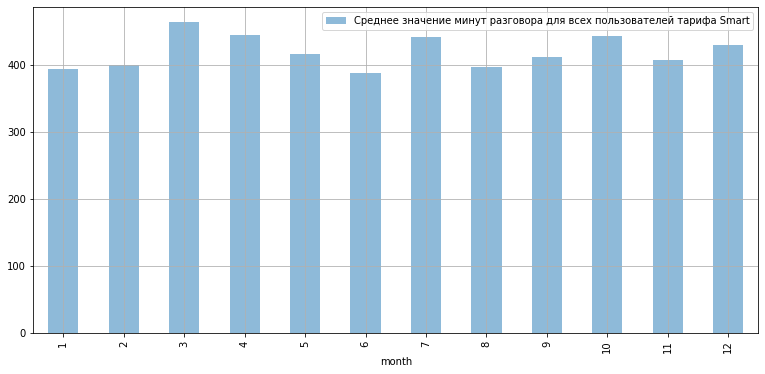

In [38]:
mean_smart.set_axis(['mean_duration','mean_mb_used','mean_message'],axis='columns',inplace=True)
mean_smart.plot(y='mean_duration',grid=True,figsize=(13,6),style='o-',kind='bar',label='Среднее значение минут разговора для всех пользователей тарифа Smart',alpha=0.5)

mean_smart

In [39]:
#находим среджнее значение для каждого месяца 
mean_smart['mean_minute_for_person']=tariff_smart['duration']/len(group_all.query('tariff=="smart"'))
smart_person_calls=group_all.query('tariff=="smart"')# записываю в переменную всех пользователей Smart для подсчета дисперсии 
smart_person_calls.head()

,user_id,message_date,duration,mb_used,city,tariff,month,money
3197,1001,0.0,430.0,18405.0,Москва,smart,11,1150.0
3198,1001,0.0,414.0,14018.0,Москва,smart,11,550.0
1724,1002,12.0,236.0,18087.0,Стерлитамак,smart,6,1150.0
1722,1002,10.0,212.0,13869.0,Стерлитамак,smart,6,550.0
1721,1002,4.0,206.0,16669.0,Стерлитамак,smart,6,750.0


#### Считаю дисперсию и отклонение для тарифа смарт по месяцам

In [40]:
smart_person_calls=group_all.query('tariff=="smart"')# записываю в переменную всех пользователей smart для подсчета дисперсии 
smart_person_calls.head()

,user_id,message_date,duration,mb_used,city,tariff,month,money
3197,1001,0.0,430.0,18405.0,Москва,smart,11,1150.0
3198,1001,0.0,414.0,14018.0,Москва,smart,11,550.0
1724,1002,12.0,236.0,18087.0,Стерлитамак,smart,6,1150.0
1722,1002,10.0,212.0,13869.0,Стерлитамак,smart,6,550.0
1721,1002,4.0,206.0,16669.0,Стерлитамак,smart,6,750.0


#### Считаю дисперсию по всем показателям смарт

In [41]:
disp_sigma_smart=smart_person_calls.pivot_table(index='month',values='duration',aggfunc=(np.var))#Считаю дисперсию звонков
disp_sigma_smart_messages=smart_person_calls.pivot_table(index='month',values='message_date',aggfunc=(np.var))#Считаю дисперсию сообщений
disp_sigma_smart_internet=smart_person_calls.pivot_table(index='month',values='mb_used',aggfunc=(np.var))#Считаю дисперсию интернет

#### Считаю стандартное отклонение по всем показателям Смарт

In [42]:
disp_sigma_smart['sigma']=disp_sigma_smart['duration'].apply(np.sqrt)#Считаю стандартное отклонение по звонкам
disp_sigma_smart_messages['sigma']=disp_sigma_smart_messages['message_date'].apply(np.sqrt)#Считаю стандартное отклонение по cообщениям
disp_sigma_smart_internet['sigma']=disp_sigma_smart_internet['mb_used'].apply(np.sqrt)#Считаю стандартное отклонение по интернетуsmart
disp_sigma_smart.set_axis(['dispersion_call','sigma_call'],axis='columns',inplace=True)
disp_sigma_smart_messages.set_axis(['dispersion_message','sigma_message'],axis='columns',inplace=True)
disp_sigma_smart_internet.set_axis(['dispersion_internet','sigma_internet'],axis='columns',inplace=True)# Переименовываю столбцы
disp_sigma_smart=disp_sigma_smart.merge(disp_sigma_smart_messages,on='month')
disp_sigma_smart=disp_sigma_smart.merge(disp_sigma_smart_internet,on='month')
mean_smart['mean_money']=group_all.query('tariff=="smart"').pivot_table(index='month',values='money',aggfunc=('mean')) # Считаю среднее по прибыли
mean_smart['dispersion_money']=group_all.query('tariff=="smart"').pivot_table(index='month',values='money',aggfunc=(np.var)) # Считаю среднее по прибыли
mean_smart['sigma_money']=np.sqrt(mean_smart['dispersion_money'])
mean_smart=mean_smart.merge(disp_sigma_smart,on='month')

#### Полная таблица дисперсии и сигма (среднеквадратичное отклонение),средних для смарт по месяцам

In [43]:
mean_smart

,mean_duration,mean_mb_used,mean_message,mean_minute_for_person,mean_money,dispersion_money,sigma_money,dispersion_call,sigma_call,dispersion_message,sigma_message,dispersion_internet,sigma_internet
month,,,,,,,,,,,,,
1,393.527228,15813.799505,34.101485,71.293722,1105.952970,3.952180e+05,628.663643,35379.401242,188.094129,532.736573,23.081087,2.758262e+07,5251.915669
2,399.555985,15003.247104,35.065637,46.405830,1075.007722,4.323933e+05,657.566208,31821.480381,178.385763,1029.689474,32.088775,3.327970e+07,5768.855635
3,462.773684,17168.389474,36.921053,39.429148,1316.584211,4.436624e+05,666.079838,27443.350627,165.660347,649.184211,25.479094,2.622779e+07,5121.307463
4,443.407051,16119.445513,36.474359,62.037220,1129.176282,4.028129e+05,634.675448,28001.554034,167.336649,696.700305,26.395081,2.303587e+07,4799.570118
5,416.078261,17655.791304,34.047826,42.913901,1423.508696,6.670106e+05,816.707180,32731.094285,180.917369,1132.630890,33.654582,3.632530e+07,6027.047171
6,387.012579,16956.459119,27.176101,27.594170,1317.220126,7.632115e+05,873.619748,36180.594777,190.211973,580.310564,24.089636,3.952488e+07,6286.881620
7,441.110092,15775.307339,32.981651,43.121973,1195.729358,5.094057e+05,713.726622,34008.236672,184.413223,850.746206,29.167554,3.267226e+07,5715.965288
8,396.881657,16482.017751,28.295858,30.077578,1276.218935,6.395034e+05,799.689534,46668.474007,216.028873,799.721471,28.279347,3.374659e+07,5809.181822
9,411.184466,16193.359223,34.621359,18.991928,1313.427184,7.206793e+05,848.928305,40291.347992,200.727048,1066.335618,32.654795,4.527958e+07,6729.010174


### Возвращаемся к таблицам ultra_person_calls и smart_person_calls, в котором все пользователи Ультра и Смарт, построим гистограммы.

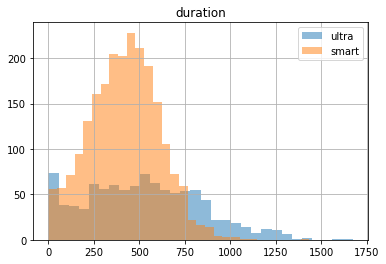

In [44]:
#Строим гистограммы звонков
ax=ultra_person_calls.hist(column='duration',alpha=0.5, bins=30,label='ultra')
smart_person_calls.hist(column='duration', bins=30,alpha=0.5,ax=ax, label='smart');
plt.legend()
plt.show()

Построили две гистрограммы где видим что пользователи тарифа смарт разговарива/т в целом не больше 10 минут, когда пользователь тарифа тсмарт разговаривают около 100-120 минут

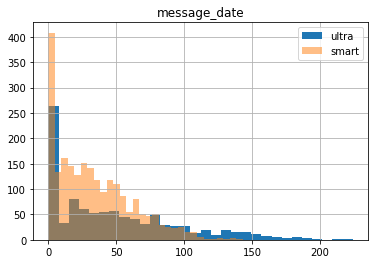

In [45]:
#Строим гистограммы смс
ax=ultra_person_calls.hist(column='message_date', bins=30, label='ultra')
smart_person_calls.hist(column='message_date', bins=30,alpha=0.5,ax=ax, label='smart');
plt.legend()
plt.show()

Построили две гистрограммы где видим что пользователи тарифа смарт отправляют меньше смс чем пользователи тарифа смарт

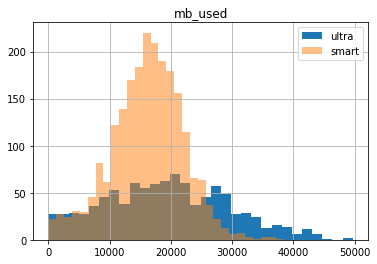

In [46]:
#Строим гистограммы смс
ax=ultra_person_calls.hist(column='mb_used', bins=30, label='ultra')
smart_person_calls.hist(column='mb_used', bins=30,alpha=0.5,ax=ax, label='smart')
plt.legend()
plt.show()

Посмотрев данные гистограммы делаем вывод, что пользователи тарифа смарт используют больше интернета чем пользователи Ультра

## Проверка гипотезы
 

### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

Нулевая гипотеза для первой задачи гласит: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна".

Альтернативаня гипотеза первой задачи: "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается".

In [47]:
alpha=0.05 # критический уровень статистической значимости
ultra_all=group_all.query('tariff=="ultra"')
smart_all=group_all.query('tariff=="smart"')
ultra_all['money'].mean() # Среднее значение выречки пользователей Ультра
disp_ultra=np.var(ultra_all['money'])
print('99% значений попадают с интервал:+-',round(3*np.sqrt(disp_ultra)),'от среднего значения',round(ultra_all['money'].mean()))

99% значений попадают с интервал:+- 1059 от среднего значения 2059


доверительный интрвал для тарифа ультра 95%

In [48]:
st.t.interval(0.95, len(ultra_all['money'])-1, loc=np.mean(ultra_all['money']), scale=st.sem(ultra_all['money']))
smart_all['money'].mean() # Среднее значение выручки пользователей Смарт
disp_smart=np.var(smart_all['money'])
print('99% значений попадают с интервал:+-',round(3*np.sqrt(disp_smart)),'от среднего значения',round(smart_all['money'].mean()))

99% значений попадают с интервал:+- 2349 от среднего значения 1225


доверительный интрвал для тарифа смарт 95%

In [53]:
st.t.interval(0.95, len(smart_all['money'])-1, loc=np.mean(smart_all['money']), scale=st.sem(smart_all['money']))
print(smart_all['money'].var())#Дисперсия выручки Смарт
print(ultra_all['money'].var()) #Дисперсия выручки Смарт

613511.8656778663
124834.23770348329


Значения дисперсии сильно отличаются. Поэтому в функции st.ttest_ind буду использовать параметр equal_var=False

In [50]:
result=st.ttest_ind(smart_all['money'],ultra_all['money'],equal_var=False)
print(result.pvalue) #выведем p-value из результата
if (result.pvalue<alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилость отвергнуть нулевую гипотезу')

5.4657459530897046e-303
Отвергаем нулевую гипотезу


Выдвинем предположение о равенстве выборки по каждому тарифу с генеральной совокупностью.

При сравнении статистических данных выборок с генеральной выборкой видно, что нормальное распределения каждого тарифа отличаются друг от друга

In [51]:
interested_value=smart_all['money'].mean() # среднее значение smart. относительно которого проверяем
result=st.ttest_1samp(ultra_all['money'],interested_value)
print(result.pvalue/2) #p-value
if (result.pvalue/2<alpha) and (ultra_all['money'].mean()<=interested_value):
     print('Отвергаем нулевую гипотезу')
else:
    print('Не получилость отвергнуть нулевую гипотезу')

0.0
Не получилость отвергнуть нулевую гипотезу


При проверке односторонней гипотезы "среднее значение выручки Ультра меньше предполагаемого(значение Смарт)", отвергли, если выполнелось два условия:

среднее значение выручки Ультра <= предполагаемого(значение Смарт)
разница среднего значения и статистической значимости деленой пополам была существенной
Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. Нулевая гипотеза звучит так: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

In [52]:
moscow_all=group_all.query('city=="Москва"')
other_all=group_all.query('city!="Москва"')
alpha=0.05
moscow_all['money'].var()
moscow_all['money'].mean()
other_all['money'].var()
other_all['money'].mean()
result=st.ttest_ind(moscow_all['money'],other_all['money'])
print(result.pvalue)
if (result.pvalue<alpha):
    print('Отвергаем гипотизу')
else:
    print('Гипотизу отвергнуть не удалось')

0.5126385378243601
Гипотизу отвергнуть не удалось


Гипотезу отвергаем. Средняя выручка в Москве отличается от средней выручки в регионах.



**Итоговый вывод**

В ходе проделанной работы было выполнено:

Просмотрена каждая таблица и выявлены аномалии и связи между таблицами

Составлена общая таблица данных о пользователях сети

Заполнены пропуски и сменены типы данных для столцов

Добавлены необходимые серии для гипотез

Проведен сравнительный анализ пользователей тарифов

Проверены гипотезы на возможное соотвествие

Предложенные тарифы сильно отличаются друг от друга и их выручка разнится. В первую очередь пользователи тарифа Smart чаще пользователей тарифа Ultra перерасходуют лимиты. Из-за это выручка по тарифу Smart может казаться большой.

Сравнение процента пользователей, которые не переходят за порог 25% для Smart и 86% для Ultra, говорит о том, что первый тариф не соответвует большинству пользователей практически по всем пунктам (более половины случаев переплат только за интернет). Второму тарифу слишком много лимита по минутам и смс и перерасход может быть только по интернету (14% пользователей).

В процессе работы, было выявлено, что в целом данные приходят без артефактов и достаточно чистые, за исключением столбца churn_date таблицы users и нулевые звонки в таблице calls. таких данных лучше избегать. Я бы предложил при их сборе дополнительно помечать абонентов каким то максимально разумным значением или же условным нулем, чтобы упростить анализ, тем что нет необходимости дополнительно придумывать условные флаги, которые сможет переработать компьютер.К тому же если над подобными данными будут работать несколько сотрудников и каждый из них определит для себя индивидуальный флаг, то в дальнейшем при объединении работ могут появиться баги, которые сложно будет отловить.

Рекламный бюджет выгоднее всего перераспределить в пользу тарифа ultra, несмотря на то, что его абоненты не покупают дополнительные минуты и смс, в отличие от абонентов тарифа smart. Так же можно заметить, что медианное и среднее значение дохода у абонентов тарифа ultra выше.

Так же исследовав предоставленные данные мы смогли проверить гипотезы. Эти данные помогли нам опровергнуть гипотезу о том, что средняя выручка пользователей разных тарифов равна, а так же с большой вероятностью сказать, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.


